In [1]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('../data/final_data.csv')

In [3]:
df.isna().sum() / len(df) * 100

short_descriptions    1.620004
assignment_groups     1.614584
dtype: float64

In [4]:
df.shape

(166049, 2)

In [5]:
non_dupl = df[~df.duplicated()].copy()
non_dupl.shape

(116739, 2)

In [6]:
non_dupl.isna().sum() / len(non_dupl) * 100

short_descriptions    0.004283
assignment_groups     0.009423
dtype: float64

In [7]:
non_dupl.dropna(inplace=True)

In [8]:
non_dupl.tail()

,short_descriptions,assignment_groups
166044,Data files per our call,PZC-FJ-ServiceDesk
166045,Approver Matrix,PZC-FJ-ServiceDesk
166046,a new Product Hierarchy Level 5 and 6: Vegeta...,PZC-FJ-ServiceDesk
166047,[SAP] Create SAP account in PROD for Charala...,PZC-FJ-ServiceDesk
166048,APO Daily and Monthly Chains to be triggere...,PZC-FJ-ServiceDesk


In [9]:
non_dupl['short_descriptions'] = non_dupl['short_descriptions'][
    non_dupl['short_descriptions'].apply(lambda x: len(x.split()) > 1) == True]

In [10]:
non_dupl.isna().sum() / len(non_dupl) * 100

short_descriptions    0.764196
assignment_groups     0.000000
dtype: float64

In [11]:
non_dupl.dropna(inplace=True)

In [12]:
non_dupl.head()

,short_descriptions,assignment_groups
0,Unlock user access,G SNOW EXT ATOS IDM ADMINS
2,Please grant access to roles for TPM approvals,G SNOW EXT ATOS CENTRAL USER ACCESS TEAM
4,IT - 3PL user password reset,G SNOW IT SERVICE DESK
5,RS - Request for SAP authorizations,G SNOW RS SERVICE DESK
6,please modify the user in template,G SNOW IT SERVICE DESK


In [13]:
non_dupl.shape

(115832, 2)

C:\ProgramData\Miniconda3\envs\AIOps\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\AIOps\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0, flags=flags)


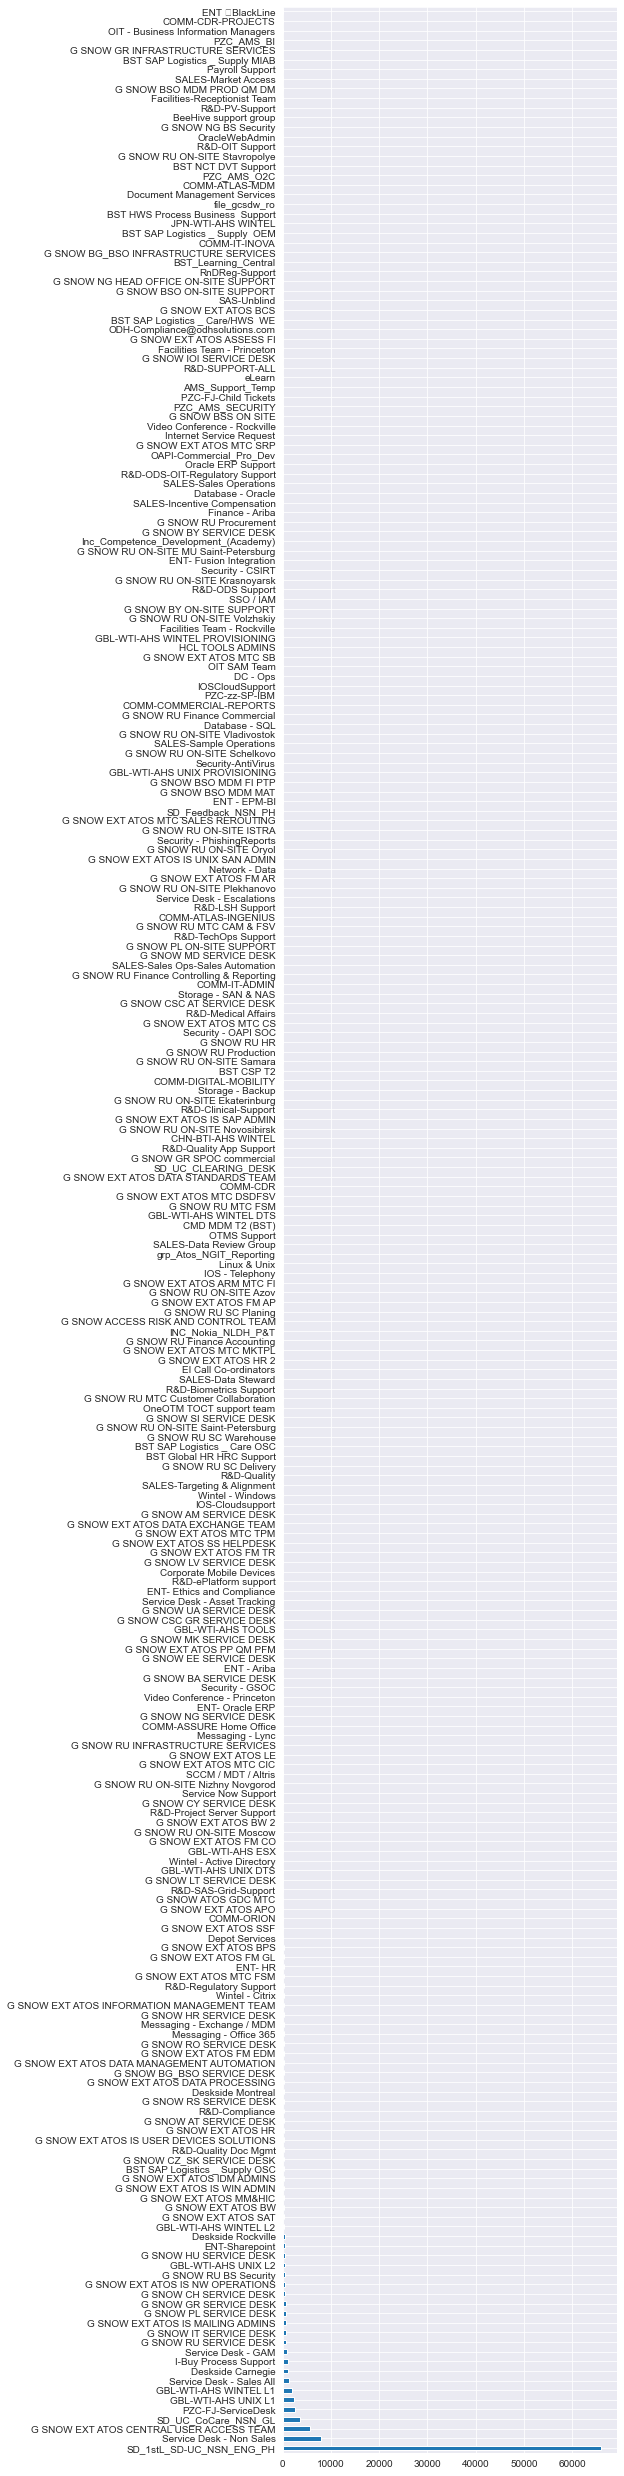

In [14]:
cnt_asgn_grps = non_dupl['assignment_groups'].value_counts()

cnt_asgn_grps.plot(kind='barh', figsize=(6, 45))
plt.show()

In [15]:
cnt_asgn_grps.min(), cnt_asgn_grps.max()

(1, 66041)

In [16]:
counts = sorted(cnt_asgn_grps, reverse=True)

In [17]:
len(counts)

254

In [18]:
len([f for f in counts if f > 200])

51

In [19]:
cnt_asgn_grps.head()

SD_1stL_SD-UC_NSN_ENG_PH                    66041
Service Desk - Non Sales                     8050
G SNOW EXT ATOS CENTRAL USER ACCESS TEAM     5718
SD_UC_CoCare_NSN_GL                          3563
PZC-FJ-ServiceDesk                           2632
Name: assignment_groups, dtype: int64

In [20]:
51 * 8050

410550

In [21]:
max_class = non_dupl[non_dupl['assignment_groups'] == 'SD_1stL_SD-UC_NSN_ENG_PH']

In [22]:
max_class = max_class.sample(8050)

In [23]:
test_df = non_dupl[~non_dupl['assignment_groups'].isin(['SD_1stL_SD-UC_NSN_ENG_PH'])]

In [24]:
cnts = test_df['assignment_groups'].value_counts()

In [25]:
valid_labels = cnts[cnts > 200]

In [26]:
test_df = non_dupl[non_dupl['assignment_groups'].isin(valid_labels.index.to_list())]

In [27]:
test_df.shape

(43837, 2)

In [28]:
new_df = test_df.append(max_class)
new_df = new_df.sample(frac=1)

In [29]:
new_df.shape

(51887, 2)

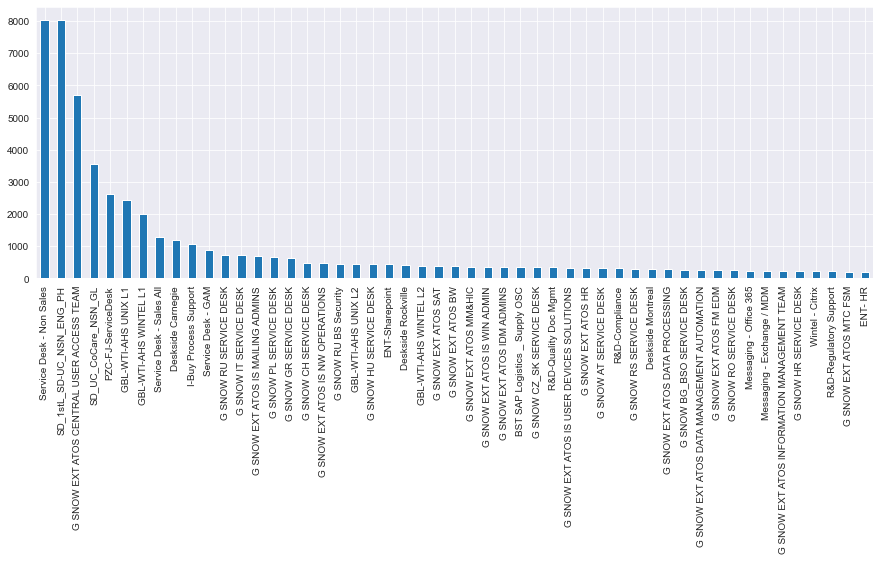

In [30]:
new_df['assignment_groups'].value_counts().plot(kind='bar', figsize=(15, 5))
plt.show()

In [31]:
X, y = new_df['short_descriptions'], new_df['assignment_groups']

In [32]:
X.size, y.size

(51887, 51887)

In [33]:
counts = sorted(Counter(y).values(), reverse=True)

In [34]:
len(Counter(y)) * counts[0]

410550

In [35]:
from imblearn.over_sampling import SMOTE

In [36]:
over_sampler = SMOTE()

In [37]:
vectorizer = CountVectorizer()
encoder = LabelEncoder()

In [38]:
X_vec = vectorizer.fit_transform(X)
y_enc = encoder.fit_transform(y)

In [39]:
%%time

X, y = over_sampler.fit_resample(X_vec, y_enc)

Wall time: 2.94 s


In [40]:
%%time

X = vectorizer.inverse_transform(X)
y = encoder.inverse_transform(y)

Wall time: 1min 9s


In [41]:
len(X), len(y)

(410550, 410550)

In [42]:
res_df = pd.DataFrame(
    {
        'short_descriptions': X,
        'assignment_groups': y
    }
)

In [43]:
res_df.shape

(410550, 2)

In [44]:
res_df.tail()

,short_descriptions,assignment_groups
410545,[],Wintel - Citrix
410546,"[not, outlook]",Wintel - Citrix
410547,[is],Wintel - Citrix
410548,[desktop],Wintel - Citrix
410549,"[citrix, desktop, issue]",Wintel - Citrix


In [45]:
def clean_text(text):
    return ' '.join([t for t in text])

In [46]:
res_df['short_descriptions'] = res_df['short_descriptions'].apply(lambda x:clean_text(x))

In [47]:
res_df.tail()

,short_descriptions,assignment_groups
410545,,Wintel - Citrix
410546,not outlook,Wintel - Citrix
410547,is,Wintel - Citrix
410548,desktop,Wintel - Citrix
410549,citrix desktop issue,Wintel - Citrix


<AxesSubplot:>

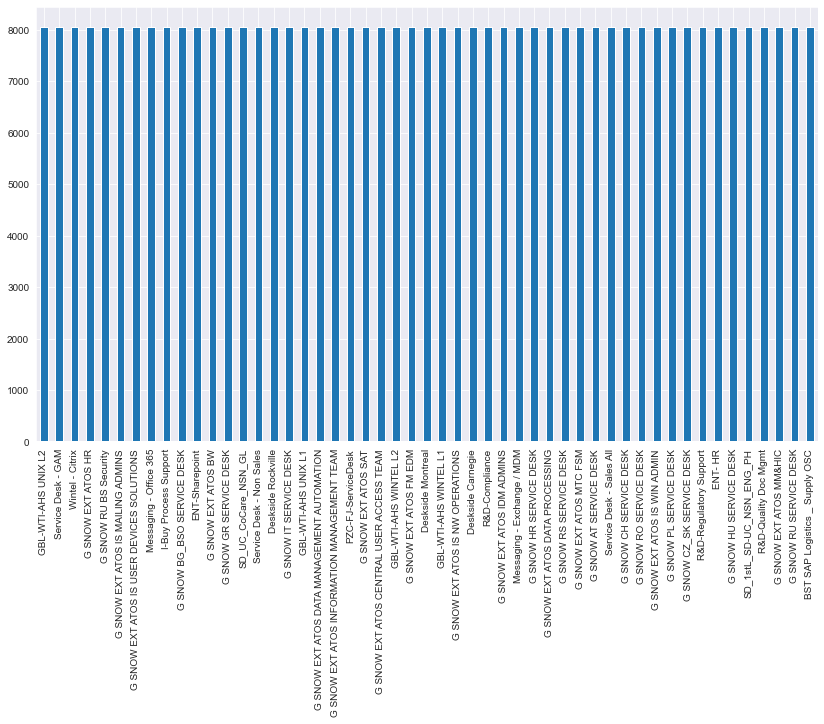

In [48]:
res_df['assignment_groups'].value_counts().plot(kind='bar', figsize=(14, 8))

In [49]:
res_df.to_csv('../data/new_balanced_data_200.csv', index=False)

In [50]:
joblib.dump(vectorizer, '../models/vectorizer', compress=2)

['../models/vectorizer']

In [51]:
joblib.dump(encoder, '../models/encoder', compress=2)

['../models/encoder']